# Exploratory Data Analysis


**Research Questions**

- **RQ1:** Which socioeconomic and geographic factors most strongly predict food affordability in California?
- **RQ2:** Are there statistically significant differences in food affordability across regions, geotypes (urban vs rural), and income levels?
- **RQ3:** Does the effect of income or cost differ by region or race? (Possible interactions)
- **RQ4:** When all predictors are considered together, which variables contribute the most to predicting affordability?

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [26]:
df = pd.read_csv('./data/food_affordability.csv')
df.shape

(14365, 23)

In [27]:
df.head(3)

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,...,median_income,affordability_ratio,LL95_affordability_ratio,UL95_affordability_ratio,se_food_afford,rse_food_afford,food_afford_decile,CA_RR_Affordability,ave_fam_size,version
0,757,Food affordability for female-headed household...,2006-2010,1.0,AIAN,CA,6.0,California,NaN,NaN,...,23777.0,0.315779,0.231517,0.400043,0.042991,13.614342,NaN,1.185347,3.34,4/12/2013 4:33
1,757,Food affordability for female-headed household...,2006-2010,2.0,Asian,CA,6.0,California,NaN,NaN,...,38508.0,0.194980,0.183065,0.206895,0.006079,3.117814,NaN,0.731900,3.34,4/12/2013 4:33
2,757,Food affordability for female-headed household...,2006-2010,3.0,AfricanAm,CA,6.0,California,NaN,NaN,...,26192.0,0.286664,0.279661,0.293666,0.003573,1.246349,NaN,1.076054,3.34,4/12/2013 4:33


## 1. Data Cleaning and Preprocessing


### 1.1 Columns Removed and Rationale

The columns version, ind_definition, ind_id, and reportyear contain no analytical variation and are identical across all rows. Since all observations represent the same indicator (food affordability for female-headed households with children under 18, indicator code 757) reported over the 2006–2010 period, these fields do not provide additional information for analysis. To simplify the dataset and reduce unnecessary dimensionality, these columns are removed.

In [28]:
drop_cols = ["version", "ind_definition", "ind_id", "reportyear"]
df = df.drop(columns=drop_cols)

In [29]:
df.columns

Index(['race_eth_code', 'race_eth_name', 'geotype', 'geotypevalue', 'geoname',
       'county_name', 'county_fips', 'region_name', 'region_code', 'cost_yr',
       'median_income', 'affordability_ratio', 'LL95_affordability_ratio',
       'UL95_affordability_ratio', 'se_food_afford', 'rse_food_afford',
       'food_afford_decile', 'CA_RR_Affordability', 'ave_fam_size'],
      dtype='object')

### 1.2 Handling Missing Values

In [30]:
# --------------------------------------------
# 1) Keep only rows where the target and key predictor exist
# --------------------------------------------

original_df = df.copy()

df_cleaned = original_df[
    original_df["affordability_ratio"].notna() &
    original_df["cost_yr"].notna()
]

print("Rows after filtering:", df_cleaned.shape)

# --------------------------------------------
# 2) Drop secondary statistical fields (CI bounds, SE values)
#    These variables are not used in hypothesis testing or modeling.
# --------------------------------------------

drop_stats_cols = [
    "LL95_affordability_ratio",
    "UL95_affordability_ratio",
    "se_food_afford",
    "rse_food_afford",
]

df_cleaned = df_cleaned.drop(columns=drop_stats_cols, errors="ignore")

# --------------------------------------------
# 3) Drop optional geographic detail fields 
#    (county_name, county_fips, region_code) — region_name is sufficient.
# --------------------------------------------

drop_geo_cols = ["county_name", "county_fips", "region_code"]

df_cleaned = df_cleaned.drop(columns=drop_geo_cols, errors="ignore")

# --------------------------------------------
# 4) Optionally drop ave_fam_size (if not used as predictor)
# --------------------------------------------

df_cleaned = df_cleaned.drop(columns=["ave_fam_size"], errors="ignore")

# --------------------------------------------
# 5) Final missing check
# --------------------------------------------

df = df_cleaned
df.isna().sum()

Rows after filtering: (3473, 19)


race_eth_code             0
race_eth_name             0
geotype                   0
geotypevalue              0
geoname                   0
region_name               0
cost_yr                   0
median_income             0
affordability_ratio       0
food_afford_decile     2513
CA_RR_Affordability       0
dtype: int64

**Column Explanation**
- `race_eth_code`:

The variables dropped from the dataset are either secondary statistical outputs 
(e.g., confidence interval bounds and standard errors), or fields that are not aligned 
with our analytical goals (e.g., county identifiers when our analysis is at the 
regional level). Many of these fields contain a substantial number of missing values, 
and retaining them would reduce the effective sample size or require imputation that 
does not meaningfully improve the analysis.

Because these variables are neither essential predictors nor required for our 
hypothesis testing and modeling objectives, removing them simplifies the dataset 
without sacrificing analytical value.

**One exception** is the `food_afford_decile` variable. Although this column contains many apparent missing values (2,513), this is a structural property of the dataset rather than true missingness—the decile is only defined for rows where `race_eth_name = "total"`. This variable provides meaningful categorical insight into relative affordability rankings across regions and is useful for exploratory visualization, so we retain it for EDA purposes even though it will not be used for modeling.

## 2. Explatory Data Analysis

### 2.1 Distribution of the Target Variable (Affordability Ratio)

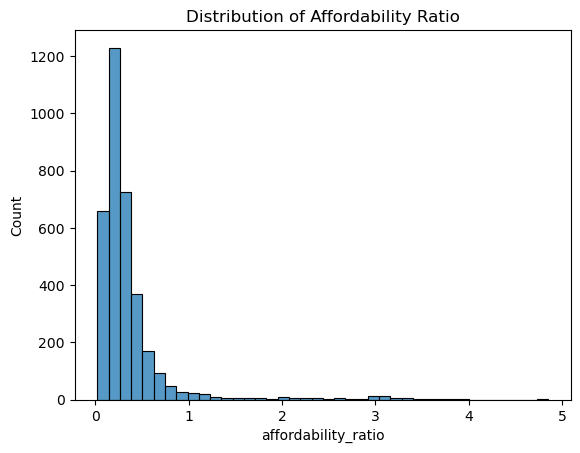

In [31]:
sns.histplot(df["affordability_ratio"], bins=40)
plt.title("Distribution of Affordability Ratio")
plt.show()

The distribution of the affordability ratio is highly right-skewed.
Most observations fall between 0.1 and 0.5, indicating that in the majority of California regions, annual food costs account for a relatively small share of median income.
However, a small number of regions exhibit extremely high affordability ratios (above 1, with some reaching 3–5), suggesting severe food cost burden in those areas.

This heavy-tailed pattern indicates clear outliers and substantial heterogeneity across regions.
From a modeling perspective, this skewness suggests that linear regression models may be sensitive to outlier influence and may violate normality assumptions.
A log transformation of the target or the use of more robust tree-based models such as Random Forests or Gradient Boosting may therefore be more appropriate.

In the context of hypothesis testing, the strong deviation from normality also implies that strict normality assumptions for ANOVA or t-tests may not be fully satisfied.
However, the large sample size helps mitigate this issue through the Central Limit Theorem.
Given the extent of non-normality, non-parametric alternatives such as the Kruskal–Wallis test may also be considered when appropriate.


### 2.2 Summary Statistics of Key Numerical Variables

In [32]:
df[["cost_yr", "median_income", "affordability_ratio"]].describe()

,cost_yr,median_income,affordability_ratio
count,3473.000000,3473.000000,3473.000000
mean,7347.294244,35985.685081,0.357114
std,1177.577978,27436.558125,0.451169
min,3550.188000,2500.000000,0.021258
25%,6646.580520,20219.000000,0.158028
50%,7246.521164,30371.000000,0.245429
75%,7975.792231,44083.000000,0.381940
max,16872.049536,250000.000000,4.852371


The summary statistics of the key numerical variables reveal several important patterns:

- **Food cost per year (cost_yr)** ranges from about \$3,095 to \$16,872, with a median of \$7,149.  
  The interquartile range (IQR ≈ \$6,253–\$8,083) shows that most regions fall within a relatively narrow band of annual food expenses, though a few areas experience substantially higher costs, as indicated by the long right tail.

- **Median income** varies dramatically across regions, ranging from \$2,500 to \$250,000.  
  The very large standard deviation (≈ \$27,436) and the wide gap between the 25th percentile (\$20,219) and the 75th percentile (\$44,803) indicate large socioeconomic disparities across California counties.  
  This variation suggests that income is likely to be a major explanatory variable for food affordability.

- **Affordability ratio** (food cost as a share of income) has a median of approximately **0.245**, meaning that in a typical region, food costs represent about **24–25% of median income**.  
  However, the affordability ratio ranges from 0.02 to 4.85, indicating substantial inequality. 
A ratio of 4.85 means that in some regions, annual food costs are nearly five times 
the median income, reflecting severe affordability challenges.
  The mean (0.357) being higher than the median further reflects strong right skew, consistent with the distribution observed earlier.

Overall, these summary statistics highlight substantial heterogeneity in both income and food affordability across regions, motivating the need for formal hypothesis testing and subsequent modeling to better understand the drivers of these disparities.


### 2.3 Interpretation of the Scatterplot: Food Cost vs. Median Income

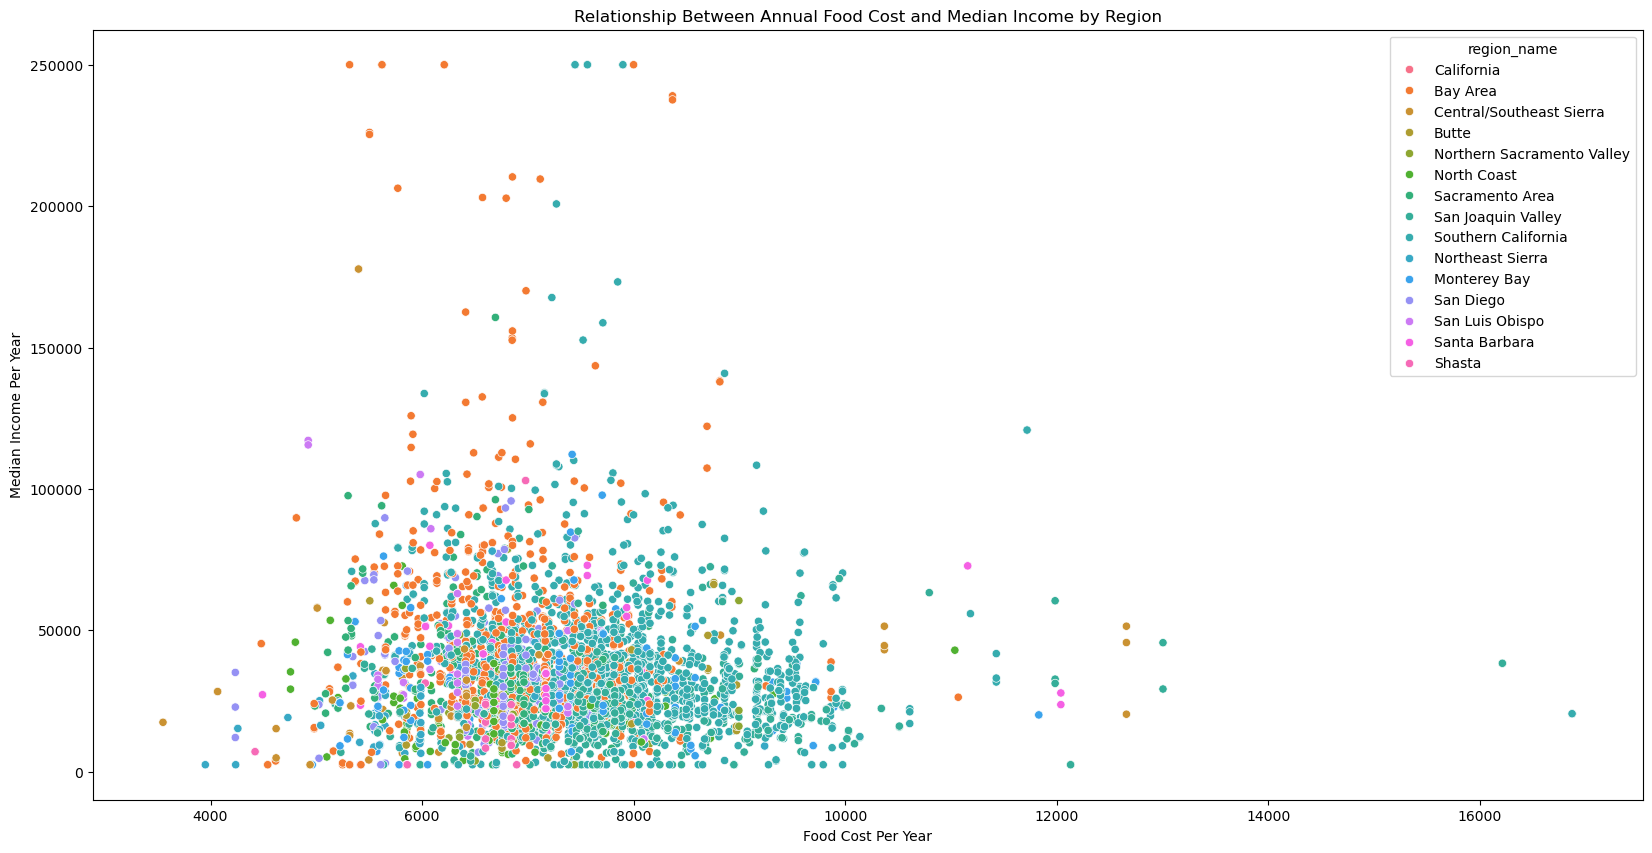

In [33]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df, 
            x = "cost_yr",
            y = "median_income",
            hue = "region_name",
            )

plt.title("Relationship Between Annual Food Cost and Median Income by Region")
plt.xlabel("Food Cost Per Year")
plt.ylabel("Median Income Per Year")
plt.show()

The scatterplot reveals several important patterns about the relationship between annual food cost and median income across California regions:

**1. Food costs do not strongly increase with income.**
Although median income ranges widely—from as low as \$2,500 to over \$250,000—annual food costs remain tightly clustered between \$6,000 and \$9,000 for most regions. This indicates that food cost is relatively inelastic and does not scale proportionately with income.

**2. Lower-income regions face a substantially higher food burden.**
Because food costs stay within a narrow range regardless of income level, households in low-income areas spend a much larger share of their income on food. This directly supports the observed right-skewed distribution of the affordability ratio and highlights significant inequality across regions.

**3. Regional clusters are highly overlapping.**
The colors representing different regions do not form distinct clusters, suggesting that differences in food cost and income are not solely determined by geographic region. This implies that region_name may be a weak standalone predictor and that additional socioeconomic features are needed to explain affordability differences.

**4. Presence of outliers.**
A few regions exhibit extremely high food costs or very high incomes, indicating potential outliers. These observations may justify the use of outlier-robust models (such as Random Forest or Gradient Boosting) in later stages.

Overall, this plot demonstrates that while income varies dramatically, food costs remain relatively stable, driving large disparities in food affordability across California. This motivates further analysis of the affordability ratio and formal hypothesis testing.



### 2.4 Average Food Affordability Decile by Region


We see that only race_eth_name = total has values in the food_afford_decile column. The variable food_afford_decile ranks all California places into 10 groups (deciles) based on their food affordability. Decile 1 = least affordable and Decile 10 = most affordable.

In [34]:
region_deciles = df[df["food_afford_decile"].notna()].groupby("region_name")["food_afford_decile"].mean().sort_values()

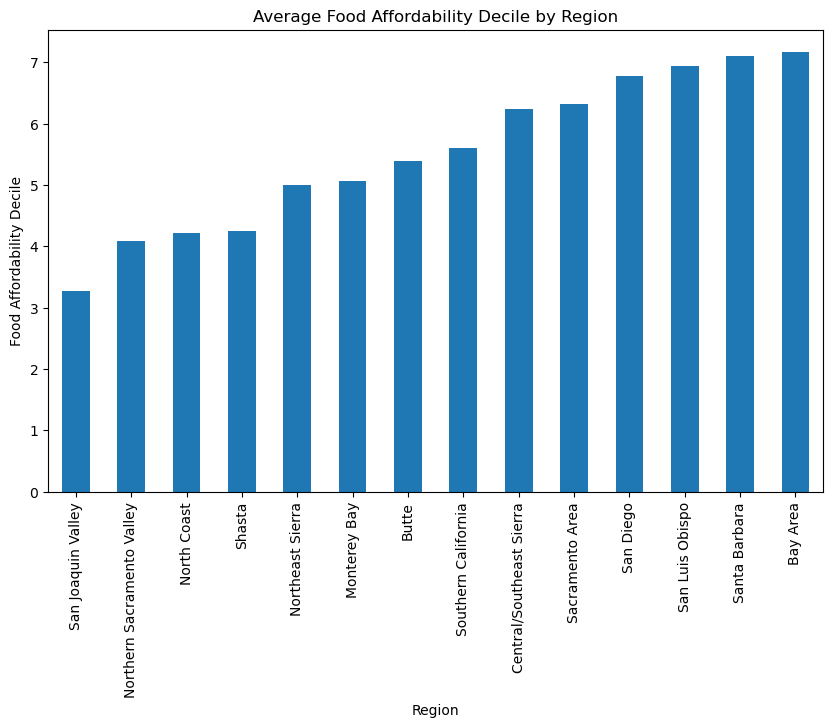

In [35]:
plt.figure(figsize=(10, 6))
region_deciles.plot.bar()

plt.xticks(rotation=90)
plt.title("Average Food Affordability Decile by Region")
plt.xlabel("Region")
plt.ylabel("Food Affordability Decile")
plt.show()

This plot shows the average food affordability decile for each California region, where a higher decile indicates more affordable food (i.e., food costs consume a smaller share of median income). The decile values are available only for rows where `race_eth_name = "total"`, which is why they can be used consistently across regions.

We observe substantial regional variation:
- **Bay Area** has the **highest affordability decile**, meaning households in this region spend a relatively small fraction of their income on food.

- **San Luis Obispo, Santa Barbara, and San Diego** also rank near the top, indicating higher affordability.

- **San Joaquin Valley** shows the **lowest affordability decile**, suggesting that households in this region face a heavier food cost burden relative to income.

Overall, this visualization highlights that **food affordability is not evenly distributed across California**, and income differences by region likely play a significant role in shaping affordability outcomes. These regional disparities motivate further analysis in the hypothesis testing and modeling sections.